numbers of missing data  
hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


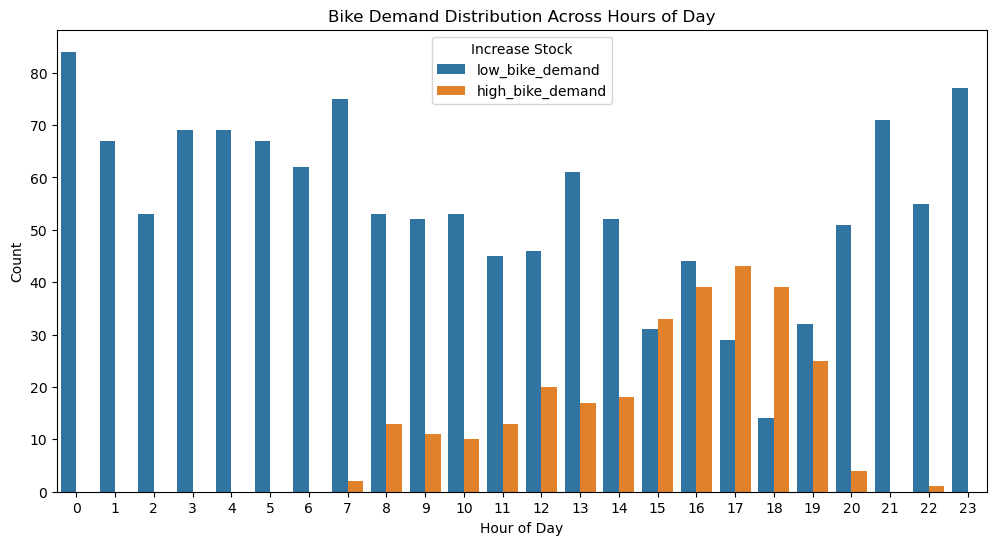

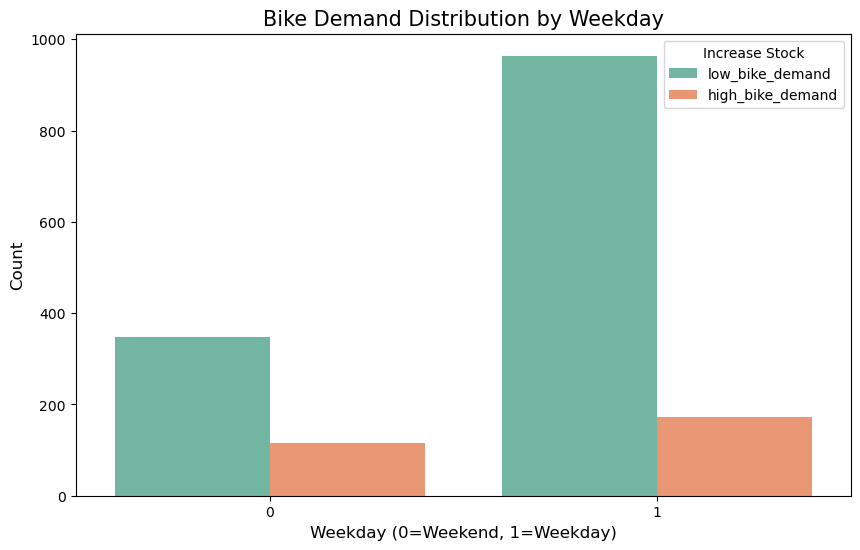

In [91]:
import pandas as pd
data = pd.read_csv('data/training_data_fall2024.csv')
"""Checking for missing values in data"""
print(f"numbers of missing data  \n{data.isnull().sum()}")
"""Nothing missed and there is no outliers"""
data
# data['holiday'].value_counts()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 data 是您的 DataFrame，包含 'hour_of_day' 和 'increase_stock' 列
# 如果您已经转换了 'hour_of_day'，请使用原始的 'hour_of_day'

# 计算每个小时段内各类别的计数
hourly_counts = data.groupby(['hour_of_day', 'increase_stock']).size().reset_index(name='count')

# 绘制条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='count', hue='increase_stock', data=hourly_counts)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Bike Demand Distribution Across Hours of Day')
plt.legend(title='Increase Stock')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='weekday', hue='increase_stock', data=data, palette='Set2')

# 添加标签和标题
plt.xlabel('Weekday (0=Weekend, 1=Weekday)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Bike Demand Distribution by Weekday', fontsize=15)

# 添加图例
plt.legend(title='Increase Stock')

# 显示图形
plt.show()

In [ ]:
stats = data.drop(columns = ["increase_stock"]).describe()
print(stats)

In [ ]:
"""When P > 0.05 we can say that the specific distribution of our data is a normal distribution"""
"""这里代码不需要修改，自己写也是这样的"""
from scipy.stats import shapiro, probplot, normaltest, kstest
from matplotlib import pyplot as plt

# A function
def normality_analysis(column_name):
    
    # Pearson test
    stat_dagostino, p_dagostino = normaltest(data[column_name])
    
    # Shapiro-Wilk test
    stat_shapiro, p_shapiro = shapiro(data[column_name])
    
    # Kolmogorov-Smirnov test
    stat_ks, p_ks = kstest(data[column_name], 'norm')
    
    # Saving results:
    results = pd.DataFrame({
        "Test": ["Shapiro-Wilk", "D'Agostino and Pearson", "Kolmogorov-Smirnov"],
        "Statistic": [stat_shapiro, stat_dagostino, stat_ks],
        "P-Value": [p_shapiro, p_dagostino, p_ks]
    })
    
    # Print the table in console
    print(f"Normality Test Results for {column_name}")
    print(results)

    # Plot histogram and Q-Q plot using matplotlib
    plt.figure(figsize=(14, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data[column_name], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(data[column_name], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {column_name}")

    plt.tight_layout()
    plt.show()

In [ ]:
for column_name in stats.columns:
        normality_analysis(column_name)

In [ ]:
from scipy.stats import spearmanr
"""Calculate the P_values"""
def p_analysis(data):
    def p_test(data):
        columns = data.columns
        spearman_matrix = pd.DataFrame(index=columns, columns=columns)
        p_value_matrix = pd.DataFrame(index=columns, columns=columns)
        for col1 in columns:
            for col2 in columns:
                if col1 != col2:
                    corr, p_value = spearmanr(data[col1], data[col2])
                    spearman_matrix.loc[col1, col2] = corr
                    p_value_matrix.loc[col1, col2] = p_value
                else:
                    spearman_matrix.loc[col1, col2] = 1
                    p_value_matrix.loc[col1, col2] = 0  
        return spearman_matrix.astype(float), p_value_matrix.astype(float)
    spearman_correlation_matrix, spearman_p_value_matrix = p_test(data)
    plt.figure(figsize=(12, 8))
    plt.imshow(spearman_correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Spearman Correlation Coefficient')
    plt.xticks(range(len(spearman_correlation_matrix.columns)), spearman_correlation_matrix.columns, rotation=45, ha='right')
    plt.yticks(range(len(spearman_correlation_matrix.columns)), spearman_correlation_matrix.columns)
    plt.title('Spearman Correlation Matrix Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()
    # Maybe we can consider that when threshold > 0.7 means two parameters are highly correlated
    threshold = 0.7
    high_spearman_corr_pairs = [
        (spearman_correlation_matrix.index[i], spearman_correlation_matrix.columns[j], spearman_correlation_matrix.iloc[i, j])
        for i in range(len(spearman_correlation_matrix.columns)) 
        for j in range(i + 1, len(spearman_correlation_matrix.columns)) 
        if abs(spearman_correlation_matrix.iloc[i, j]) > threshold and spearman_p_value_matrix.iloc[i, j] < 0.05
    ]
    
    high_spearman_corr_df = pd.DataFrame(high_spearman_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
    print(f"high_spearman_corr_df = \n{high_spearman_corr_df}")
    
"""Call p_analysis function"""
"""热图可以看出来，snow数据全部为0，而有几个数据是高度相关的，可以选择去掉一些，降低数据维度来减少计算量，然而这是主管上的看法，做不做无所谓"""
p_analysis(data)

## Update, 有关于precip和snowdepth的处理问题

In [ ]:
"""注意到，precip和snowdepth，the most of the values in columns are zero, not one, which may make no contributions to out predictions. Hence, we could check for data imbalance.
"""
"""Since snowdepth has an extremely high proportion of zeros (over 95%) and precip also has a high proportion, it would be reasonable to consider removing these columns as they may not provide much useful information for the model."""
numeric_data = data.select_dtypes(include=['float64', 'int64'])
zero_proportions = numeric_data[['precip', 'snowdepth']].apply(lambda col: (col == 0).mean())
print(f"zero_proportions = \n{zero_proportions}")

# Let plot the histogram again for these to columns again: 
for column_name in ['precip', 'snowdepth']:
        normality_analysis(column_name)

In [ ]:
"""Drop the snow cause of all values are 0"""
numeric_data = numeric_data.drop(columns=['dew', 'summertime', 'precip', 'snowdepth', 'snow'])
# use numeric_data defined above
from sklearn.preprocessing import StandardScaler
data_standardized = pd.DataFrame(StandardScaler().fit_transform(numeric_data), 
                                 columns=numeric_data.columns,
                                 index=numeric_data.index)
p_analysis(data_standardized) # Here nothing changed
data_standardized

In [93]:
"""这里对周期性的时间数据做了三角函数化处理，同时不对0-1标签的数据做正则化处理，避免PCA，随后直接模拟结果"""
# from scripts.data_preprocessing import process_time_data_scale
import numpy as np
def process_time_data_scale(data):
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    data['hour_of_day_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
    data['hour_of_day_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)

    data = data.drop(columns=['month', 'day_of_week', 'hour_of_day'], axis=1)
    # numeric_features = data.drop(['weekday', 'holiday'], axis=1)
    numeric_features = data.drop(['holiday', 'weekday'], axis=1)
    scaler = StandardScaler()
    numeric_data = pd.DataFrame(scaler.fit_transform(numeric_features),
                                columns=numeric_features.columns,
                                index=numeric_features.index)
    # return pd.concat([data[['weekday', 'holiday']], numeric_data], axis=1)
    return pd.concat([data[['holiday', 'weekday']], numeric_data], axis=1)

def process_time_data_scale(data):
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    #data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    #data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    """
    思考：每天的时间段不一样，那么是否说明，可能在白天高峰时间段需求高？我们是否需要体现？现在进行测试
    """
    # data['hour_of_day_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
    # data['hour_of_day_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)
    data['peak_hour'] = np.where((data['hour_of_day'] >= 7) & (data['hour_of_day'] <= 20), 1, 0)

    data = data.drop(columns=['month', 'day_of_week','hour_of_day'], axis=1)
    # numeric_features = data.drop(['weekday', 'holiday'], axis=1)
    numeric_features = data.drop(['weekday', 'peak_hour'], axis=1)
    scaler = StandardScaler()
    numeric_data = pd.DataFrame(scaler.fit_transform(numeric_features),
                                columns=numeric_features.columns,
                                index=numeric_features.index)
    # return pd.concat([data[['weekday', 'holiday']], numeric_data], axis=1)
    return pd.concat([data[['weekday', 'peak_hour']], numeric_data], axis=1)
numeric_data_new = data.select_dtypes(include=['float64', 'int64'])
numeric_data_new = numeric_data_new.drop(columns=['snow', 'holiday', 'precip', 'windspeed', 'weekday'])
numerical_new = process_time_data_scale(numeric_data_new)
numerical_new 

KeyError: "['weekday'] not found in axis"

In [ ]:
from scripts.class_balancing import balance_classes
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

# 将 selected_pcs 转换为 NumPy 数组
X = numerical_new.to_numpy()

# 将标签映射为 0 和 1
mapping = {'high_bike_demand': 1, 'low_bike_demand': 0}
y = data['increase_stock'].replace(mapping).to_numpy().reshape(-1, 1) 

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_bal, y_train_bal = X_train, y_train

# Sigmoid 函数
def sigmoid(z):
    # 裁剪，避免溢出错误
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# 损失函数
def computeLoss(y, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10) 
    m = len(y)
    return - (1 / m) * np.sum(
        y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)
    )

# 梯度计算
def computeGradient(X, y, y_pred):
    m = len(y)
    return (1 / m) * np.dot(X.T, (y_pred - y))  

# 梯度下降算法
def gradientDescent(X, y, learning_rate=0.01, num_iterations=1000):
    # 初始化参数
    n = X.shape[1]
    theta = np.zeros((n, 1))  
    b = 0 

    for i in range(num_iterations):
        # 计算预测值
        z = np.dot(X, theta) + b
        y_pred = sigmoid(z)

        # 计算损失
        loss = computeLoss(y, y_pred)

        # 计算梯度
        gradient_theta = computeGradient(X, y, y_pred)
        gradient_b = np.mean(y_pred - y)

        # 更新参数
        theta -= learning_rate * gradient_theta
        b -= learning_rate * gradient_b
    
    return theta, b

# 预测函数
def predict(X, theta, b, threshold=0.5):
    X = X.reshape(-1, X.shape[1]) 
    z = np.dot(X, theta) + b
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)

# 训练模型
theta, b = gradientDescent(X_train_bal, y_train_bal, learning_rate=0.01, num_iterations=2000)

# 测试集上进行预测和评估
y_test_pred = predict(X_test, theta, b)
f1_test = f1_score(y_test.flatten(), y_test_pred.flatten(), average='binary')
print(f"Test F1 Score: {f1_test:.2f}")

# 训练集上进行预测和评估
y_train_pred = predict(X_train_bal, theta, b)
f1_train = f1_score(y_train_bal.flatten(), y_train_pred.flatten(), average='binary')
print(f"Train F1 Score: {f1_train:.2f}")

# 比较训练集和测试集的F1分数
print(f"Train vs Test F1 Score: Train F1 = {f1_train:.2f}, Test F1 = {f1_test:.2f}")

# 其他评估（如准确率等）
accuracy_test = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {accuracy_test:.2f}")

# 打印分类报告
print("\nClassification Report (Test Set):")
print(classification_report(y_test.flatten(), y_test_pred.flatten(), target_names=['low_bike_demand', 'high_bike_demand']))

# 比较标签 0 和标签 1 的准确度
y_test_flat = y_test.flatten()
y_test_pred_flat = y_test_pred.flatten()

# 标签 0 的准确度
indices_class0 = np.where(y_test_flat == 0)[0]
accuracy_class0 = np.sum(y_test_pred_flat[indices_class0] == y_test_flat[indices_class0]) / len(indices_class0)
print(f"Accuracy for label 0 (low_bike_demand): {accuracy_class0:.2f}")

# 标签 1 的准确度
indices_class1 = np.where(y_test_flat == 1)[0]
accuracy_class1 = np.sum(y_test_pred_flat[indices_class1] == y_test_flat[indices_class1]) / len(indices_class1)
print(f"Accuracy for label 1 (high_bike_demand): {accuracy_class1:.2f}")

In [ ]:
scaler_standard = StandardScaler()
data_scaled = scaler_standard.fit_transform(numeric_data)
data_scaled

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca_components = pca.fit_transform(data_scaled)

# Create a DataFrame for PCA results to calculate how many components we need to keep
pca_df = pd.DataFrame(
    data=pca_components,
    index=numeric_data.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Variance Explained by Principal Components", fontsize=14)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

"""select the components that can keep at least 95% information"""
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain at least 95% variance: {n_components}")
selected_pcs = pca_df.iloc[:, :n_components]
"""Remember to convert it into a numpy array"""
selected_pcs
p_analysis(pca_df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

# 将 selected_pcs 转换为 NumPy 数组
# X = selected_pcs.to_numpy()
X = data_scaled
# 将标签映射为 0 和 1
mapping = {'high_bike_demand': 1, 'low_bike_demand': 0}
y = data['increase_stock'].replace(mapping).to_numpy().reshape(-1, 1) 
import matplotlib.pyplot as plt


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def sigmoid(z):
    # 裁剪，避免溢出错误
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def computeLoss(y, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10) 
    m = len(y)
    return - (1 / m) * np.sum(
        y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)
    )

def computeGradient(X, y, y_pred):
    m = len(y)
    return (1 / m) * np.dot(X.T, (y_pred - y))  

def gradientDescent(X, y, learning_rate=0.01, num_iterations=1000):
    # 初始化参数
    n = X.shape[1]
    theta = np.zeros((n, 1))  
    b = 0 

    for i in range(num_iterations):
        # 计算预测值
        z = np.dot(X, theta) + b
        y_pred = sigmoid(z)

        # 计算损失
        loss = computeLoss(y, y_pred)

        # 计算梯度
        gradient_theta = computeGradient(X, y, y_pred)
        gradient_b = np.mean(y_pred - y)

        # 更新参数
        theta -= learning_rate * gradient_theta
        b -= learning_rate * gradient_b
    
    return theta, b

def predict(X, theta, b, threshold=0.5):
    X = X.reshape(-1, X.shape[1]) 
    z = np.dot(X, theta) + b
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)

# 训练模型
theta, b = gradientDescent(X_train, y_train, learning_rate=0.01, num_iterations=2000)

# 测试模型
y_pred = predict(X_test, theta, b)

# 模型评估
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# 计算标签0和标签1的分别预测准确度
# 将 y_test 和 y_pred 转换为一维数组
y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# 标签0的准确度
indices_class0 = np.where(y_test_flat == 0)[0]
total_class0 = len(indices_class0)
correct_class0 = np.sum(y_pred_flat[indices_class0] == y_test_flat[indices_class0])
accuracy_class0 = correct_class0 / total_class0
print(f"Accuracy for label 0 (low_bike_demand): {accuracy_class0:.2f}")

# 标签1的准确度
indices_class1 = np.where(y_test_flat == 1)[0]
total_class1 = len(indices_class1)
correct_class1 = np.sum(y_pred_flat[indices_class1] == y_test_flat[indices_class1])
accuracy_class1 = correct_class1 / total_class1
print(f"Accuracy for label 1 (high_bike_demand): {accuracy_class1:.2f}")

# 添加 F1 分数评估
f1 = f1_score(y_test_flat, y_pred_flat, average='binary')
print(f"F1 Score: {f1:.2f}")

# 打印分类报告
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=['low_bike_demand', 'high_bike_demand']))
